## HW02 Code

### Name: Aditya Duggirala

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.  If you have trouble with the latter, a nice approach is to download in Markdown format, and then use a Markdown reader to print to PDF, which tends to produce nicer results than does printing from a browser.)

In [1]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

C:\Users\adity\AppData\Local\Temp\ipykernel_49972\43411398.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') # pretty matplotlib plots


### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:
from sklearn.linear_model import LinearRegression
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''

    prediction_list = list()
    error_list = list()
    model = LinearRegression()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    for degree in polynomials:
        # Create polynomial features
        X_poly = PolynomialFeatures(degree=degree)
        X_poly_transform = X_poly.fit_transform(x)

        # Fit a polynomial regression model
        model.fit(X_poly_transform, y)

        # Make predictions
        y_pred = model.predict(X_poly_transform)

        # Calculate MSE
        mse = mean_squared_error(y, y_pred)

        prediction_list.append(y_pred)
        error_list.append(mse)
    return prediction_list, error_list
    

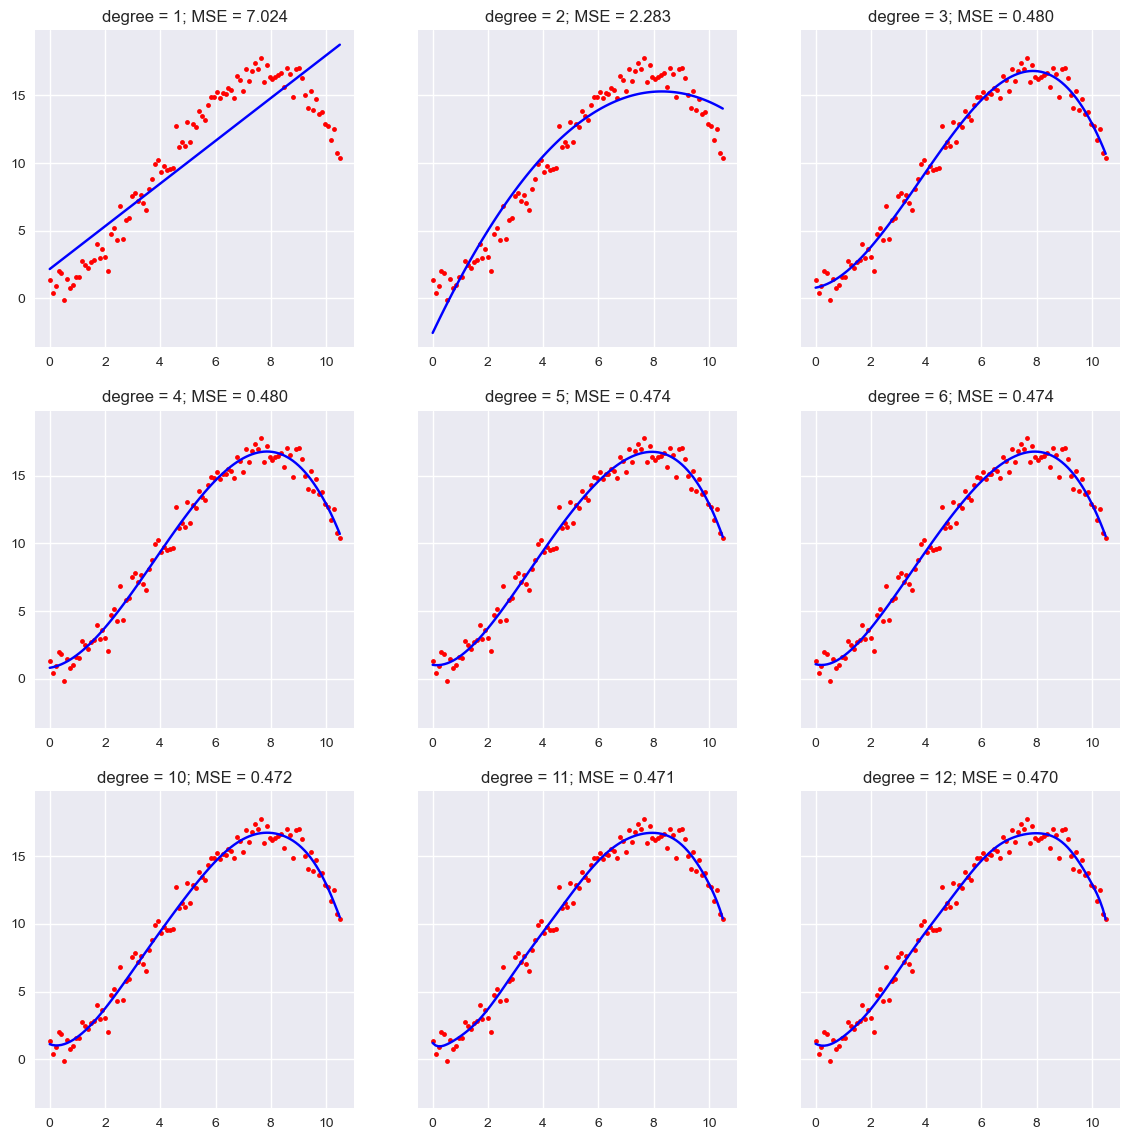

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results



# Define the sequence of degrees
degrees_sequence = [1, 2, 3, 4, 5, 6, 10, 11, 12]

# Call test_polynomials to create models
predictions, mse_values = test_polynomials(degrees_sequence)

# Plot the results using plot_predictions
plot_predictions(degrees_sequence, predictions, mse_values)




#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show from the third degree of the polynomial the prediction starts to fit the data from the excel spreadsheet. The MSE after the third degree decreases by thousands of the decimal or from the third number after the decimal point. Before the third degree, the prediction doesn't fit the data and the MSE is too high. This implies that the third degree onward have the best predictions for this dataset and we need at least the third degree to have a good prediction.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.  (**Don't modify this.**)

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

In [7]:
# A simple function for generating different data-folds.
#
# DO NOT MODIFY THIS CODE.
def make_folds(x_data, y_data, num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       x_data: input data.
       y_data: matching output data.
           (Expected that these are of the same length.)
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x_data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y_data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
        
    return x_folds, y_folds

In [8]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

Polynomial Degree | Avg. Training MSE | Avg. Testing MSE
                1 |              6.98 |            7.44
                2 |              2.25 |            2.63
                3 |              0.47 |            0.56
                4 |              0.47 |            0.57
                5 |              0.46 |            0.57
                6 |              0.46 |            0.59
               10 |              0.46 |            0.62
               11 |              0.45 |            0.65
               12 |              0.45 |            0.66


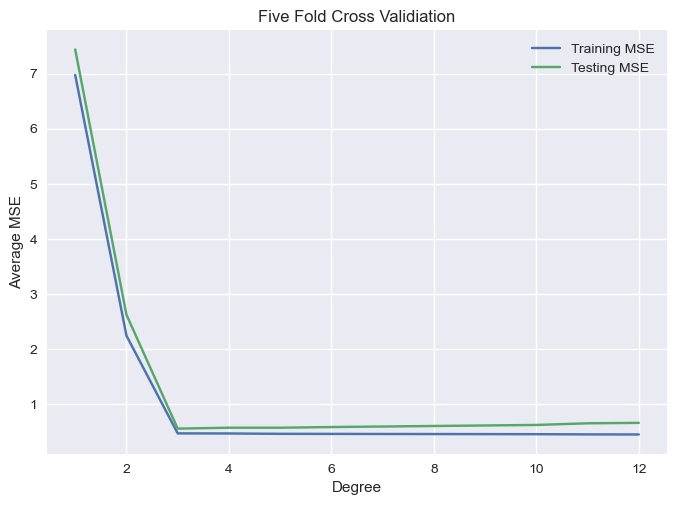

In [9]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.




from sklearn.linear_model import LinearRegression

# Define the sequence of degrees
degrees_sequence = [1, 2, 3, 4, 5, 6, 10, 11, 12]

# Create empty lists to store average training and test MSE for each degree
avg_train_mse = []
avg_test_mse = []

# Loop through each degree and perform 5-fold cross-validation
for degree in degrees_sequence:
    train_mse = []
    test_mse = []

#Loop through each fold in k and create test and training values
    for i in range(k):
        #Set values in x_folds and y_folds to be used for testing and training
        X_test  = x_folds[i] 
        y_test = y_folds[i]
        
        X_train = np.concatenate((x_folds[:i]+x_folds[i+1:]))
        y_train = np.concatenate((y_folds[:i]+y_folds[i+1:]))
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly_train_transform = poly.fit_transform(X_train)
        X_poly_test_transform = poly.fit_transform(X_test)
       

        # Fit a polynomial regression model
        model = LinearRegression()
        model.fit(X_poly_train_transform, y_train)

        # Make predictions
        y_train_pred = model.predict(X_poly_train_transform)
        y_test_pred = model.predict(X_poly_test_transform)

        # Calculate MSE
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        test_mse.append(mean_squared_error(y_test, y_test_pred))

    # Calculate average training and test MSE for this degree
    avg_train_mse.append(np.mean(train_mse))
    avg_test_mse.append(np.mean(test_mse))

# Print tabular results
print("Polynomial Degree | Avg. Training MSE | Avg. Testing MSE")
for degree, train_mse, test_mse in zip(degrees_sequence, avg_train_mse, avg_test_mse):
 print(f"{degree:17} | {train_mse:17.2f} | {test_mse:15.2f}")

# Plot results on a grid using the degrees_sequence
plt.plot(degrees_sequence, avg_train_mse, label='Training MSE')
plt.plot(degrees_sequence, avg_test_mse, label='Testing MSE')
plt.xlabel('Degree')
plt.ylabel('Average MSE')
plt.title('Five Fold Cross Validiation')
plt.legend()
plt.grid(True)
plt.show()

#### 2.2 Discuss the results seen in the plots above

**Discussion:** The results show that when the five fold cross validation is done on the third polynomial degree, the average training MSE and average test MSE are at the lowest. Before the third degree, the MSEs are decreasing but still high. And after the third degree the MSEs are gradually increasing again. So, the third degree has the best results and showed be used for the Regularized ridge regression below. The average training MSE and average test MSE are 0.47 and 0.56 respectively 

### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 3.1 Cross-validation for each regularization strength value

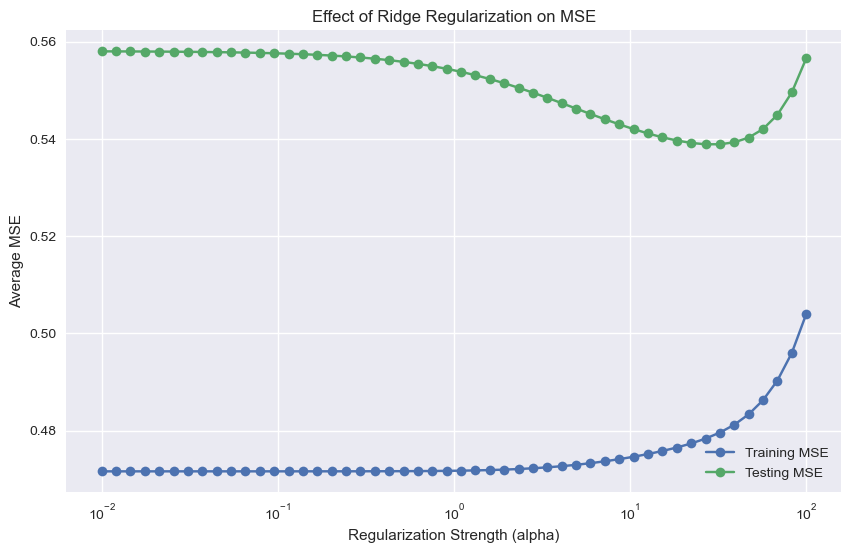

Regularization Strength (alpha) | Avg. Training MSE | Avg. Testing MSE
                        0.01 |              0.47 |            0.56
                        0.01 |              0.47 |            0.56
                        0.01 |              0.47 |            0.56
                        0.02 |              0.47 |            0.56
                        0.02 |              0.47 |            0.56
                        0.03 |              0.47 |            0.56
                        0.03 |              0.47 |            0.56
                        0.04 |              0.47 |            0.56
                        0.04 |              0.47 |            0.56
                        0.05 |              0.47 |            0.56
                        0.07 |              0.47 |            0.56
                        0.08 |              0.47 |            0.56
                        0.10 |              0.47 |            0.56
                        0.12 |              0.47 |        

In [10]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.


# Define the sequence of degrees
degrees_sequence = [1, 2, 3, 4, 5, 6, 10, 11, 12]

# Define the range of regularization strengths (logarithmic scale)
alphas = np.logspace(-2, 2, num=50)

# Create empty lists to store average training and test MSE for each alpha
avg_train_mse = []
avg_test_mse = []


# Loop through each alpha value and perform 5-fold cross-validation
for alpha in alphas:
    train_mse = []
    test_mse = []

   #Loop through each fold in k and create test and training values
    for i in range(k):
        #Set values in x_folds and y_folds to be used for testing and training
        X_test = x_folds[i]
        X_train = np.concatenate((x_folds[:i]+x_folds[i+1:]))
     
        y_test = y_folds[i]
        y_train = np.concatenate((y_folds[:i]+y_folds[i+1:]))
     
        # Create polynomial features (choose the appropriate degree)
        degree = 3  # Adjust the degree as needed
       
        poly = PolynomialFeatures(degree=degree)
        X_poly_train_transform = poly.fit_transform(X_train)
        X_poly_test_transform = poly.fit_transform(X_test)  

        # Create and fit a Ridge regression model with the current alpha
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_transform, y_train)

        # Make predictions
        y_train_pred = model.predict(X_poly_train_transform)
        y_test_pred = model.predict(X_poly_test_transform)

        # Calculate MSE
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        test_mse.append(mean_squared_error(y_test, y_test_pred))

    # Calculate average training and test MSE for this alpha
    avg_train_mse.append(np.mean(train_mse))
    avg_test_mse.append(np.mean(test_mse))

# Plot results on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.plot(alphas, avg_train_mse, label='Training MSE', marker='o')
plt.plot(alphas, avg_test_mse, label='Testing MSE', marker='o')
plt.xlabel('Regularization Strength (alpha)')
plt.ylabel('Average MSE')
plt.title('Effect of Ridge Regularization on MSE')
plt.legend()
plt.grid(True)
plt.show()

# Print tabular results
print("Regularization Strength (alpha) | Avg. Training MSE | Avg. Testing MSE")
for alpha, train_mse, test_mse in zip(alphas, avg_train_mse, avg_test_mse):
    print(f"{alpha:28.2f} | {train_mse:17.2f} | {test_mse:15.2f}")



#### 3.2 Discuss the results seen in the plots above

**Discussion**:  The results(with the third degree chosen) show that as the regularization strength increases, the average training MSE goes up gradually and the average testing MSE will go down starting from 10^0, reaches a global minimum between 10^1 and 10^2, before rising again. From the range 10^-2 to 10^0, the average training MSE is the lowest. And between 10^1 and 10^2, the average testing MSE is at the lowest point. The best regularization strenghs are 7.20, 8.69 and 10.48 since they have the lowest average training MSE and average testing MSE at 0.47 and 0.54 respectively.